In [58]:
# @title Imports
from dataclasses import dataclass
import datetime, pytz
import enum
import functools
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import time
from typing import Final, Sequence
from typing import Optional
from typing import Union, cast
os.environ['WRAPT_DISABLE_EXTENSIONS'] = 'true'
from absl import logging
import gin
import gin
from matplotlib import patches
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import reverb
import mediapy as media
from IPython.display import clear_output
import sys

gin.enter_interactive_mode()

In [59]:
from smart_control.environment import environment

from smart_control.proto import smart_control_building_pb2, smart_control_normalization_pb2
from smart_control.reward import electricity_energy_cost, natural_gas_energy_cost, setpoint_energy_carbon_reward, setpoint_energy_carbon_regret

from smart_control.simulator import randomized_arrival_departure_occupancy, rejection_simulator_building
from smart_control.simulator import simulator_building, step_function_occupancy, stochastic_convection_simulator

from smart_control.utils import bounded_action_normalizer, building_renderer, controller_reader
from smart_control.utils import controller_writer, conversion_utils, observation_normalizer, reader_lib
from smart_control.utils import writer_lib, histogram_reducer, environment_utils

In [60]:
def logging_info(*args):
    logging.info(*args)
    print(*args)


In [61]:
def remap_filepath(filepath) -> str:
    return str(filepath)

In [62]:
# @title Plotting Utities
reward_shift = 0
reward_scale = 1.0
person_productivity_hour = 300.0

KELVIN_TO_CELSIUS = 273.15

def render_env(env: environment.Environment):
    """Renders the environment."""
    building_layout = env.building._simulator._building._floor_plan

    # create a renderer
    renderer = building_renderer.BuildingRenderer(building_layout, 1)

    # get the current temps to render
    # this also is not ideal, since the temps are not fully exposed.
    # V Ideally this should be a publicly accessable field
    temps = env.building._simulator._building.temp

    input_q = env.building._simulator._building.input_q

    # render
    vmin = 285
    vmax = 305
    image = renderer.render(temps, cmap='bwr', vmin=vmin, vmax=vmax, colorbar=False, 
                            input_q=input_q, diff_range=0.5, diff_size=1,).convert('RGB')
    media.show_image(image, title='Environment %s' % env.current_simulation_timestamp)

In [63]:
from output_formatting import *
from plot_utils import *

### Setting up Gin Configs

- If you look at the config file, user defines paths and other variables within sim_config. 
- These definitions fill out those paths

In [64]:
# @title Utils for importing the environment.
data_path = "/burg/home/ssa2206/sbsim_dual_control/smart_control/configs/resources/sb1/" #@param {type:"string"}
metrics_path = "/burg/home/ssa2206/sbsim_dual_control/metrics" #@param {type:"string"}
output_data_path = '/burg/home/ssa2206/sbsim_dual_control/output' #@param {type:"string"}
root_dir = "/burg/home/ssa2206/sbsim_dual_control/root" #@param {type:"string"}


def load_environment(gin_config_file: str):
    """Returns an Environment from a config file."""
    # Global definition is required by Gin library to instantiate Environment.
    global environment  # pylint: disable=global-variable-not-assigned
    with gin.unlock_config():
        gin.parse_config_file(gin_config_file)
        return environment.Environment()  # pylint: disable=no-value-for-parameter


def get_latest_episode_reader(metrics_path: str,) -> controller_reader.ProtoReader:
    episode_infos = controller_reader.get_episode_data(metrics_path).sort_index()
    selected_episode = episode_infos.index[-1]
    episode_path = os.path.join(metrics_path, selected_episode)
    reader = controller_reader.ProtoReader(episode_path)
    return reader

@gin.configurable
def get_histogram_path():
    return data_path


@gin.configurable
def get_reset_temp_values():
    reset_temps_filepath = remap_filepath(
      os.path.join(data_path, "reset_temps.npy")
    )
    return np.load(reset_temps_filepath)


@gin.configurable
def get_zone_path():
    return remap_filepath(
      os.path.join(data_path, "double_resolution_zone_1_2.npy")
    )


@gin.configurable
def get_metrics_path():
    return os.path.join(metrics_path, "metrics")


@gin.configurable
def get_weather_path():
    return remap_filepath(os.path.join(
        data_path, "local_weather_moffett_field_20230701_20231122.csv"
      ))

In [65]:
@gin.configurable
def get_histogram_reducer():
    reader = controller_reader.ProtoReader(data_path)

    hr = histogram_reducer.HistogramReducer(
        histogram_parameters_tuples=histogram_parameters_tuples,
        reader=reader,
        normalize_reduce=True,
        )
    return hr

In [8]:
data_path = "/burg/home/ssa2206/sbsim_dual_control/smart_control/configs/resources/sb1/" #@param {type:"string"}
metrics_path = "/burg/home/ssa2206/sbsim_dual_control/metrics" #@param {type:"string"}
output_data_path = '/burg/home/ssa2206/sbsim_dual_contarol/output' #@param {type:"string"}
root_dir = "/burg/home/ssa2206/sbsim_dual_control/root" #@param {type:"string"}

In [9]:
histogram_parameters_tuples = (
        ('zone_air_temperature_sensor',(285., 286., 287., 288, 289., 290., 291., 292., 293., 294., 295., 296., 297., 298., 299., 300.,301,302,303)),
        ('supply_air_damper_percentage_command',(0.0, 0.2, 0.4, 0.6, 0.8, 1.0)),
        ('supply_air_flowrate_setpoint',( 0., 0.05, .1, .2, .3, .4, .5,  .7,  .9)),
    )

time_zone = 'US/Pacific'
collect_scenario_config = os.path.join(data_path, "sim_config.gin")
print(collect_scenario_config)
eval_scenario_config = os.path.join(data_path, "sim_config.gin")
print(eval_scenario_config)

/burg/home/ssa2206/sbsim_dual_control/smart_control/configs/resources/sb1/sim_config.gin
/burg/home/ssa2206/sbsim_dual_control/smart_control/configs/resources/sb1/sim_config.gin


In [10]:
#@title Load the environments
histogram_parameters_tuples = (
        ('zone_air_temperature_sensor',(285., 286., 287., 288, 289., 290., 291., 292., 293., 294., 295., 296., 297., 298., 299., 300.,301,302,303)),
        ('supply_air_damper_percentage_command',(0.0, 0.2, 0.4, 0.6, 0.8, 1.0)),
        ('supply_air_flowrate_setpoint',( 0., 0.05, .1, .2, .3, .4, .5,  .7,  .9)),
    )

time_zone = 'US/Pacific'
collect_scenario_config = os.path.join(data_path, "sim_config.gin")
print(collect_scenario_config)
eval_scenario_config = os.path.join(data_path, "sim_config.gin")
print(eval_scenario_config)

/burg/home/ssa2206/sbsim_dual_control/smart_control/configs/resources/sb1/sim_config.gin
/burg/home/ssa2206/sbsim_dual_control/smart_control/configs/resources/sb1/sim_config.gin


### Loading Environment

In [13]:

collect_env = load_environment(collect_scenario_config)

# For efficency, set metrics_path to None
collect_env._metrics_path = None
collect_env._occupancy_normalization_constant = 125.0

eval_env = load_environment(eval_scenario_config)
# eval_env._label += "_eval"
eval_env._metrics_path = metrics_path
eval_env._occupancy_normalization_constant = 125.0

initial_collect_env = load_environment(eval_scenario_config)

initial_collect_env._metrics_path = metrics_path
initial_collect_env._occupancy_normalization_constant = 125.0

/burg/home/ssa2206/sbsim_dual_control/smart_control/simulator/building_utils.py:283: UserWarning: Connected components is showing that there are 4 or fewer
     rooms in your building. You may have your 0's and 1's inverted in the
     floor_plan. Remember that for the connectedComponents function,
     0's must code for exterior space and exterior or interior walls,
     and 1's must code for interior space.
  warnings.warn("""Connected components is showing that there are 4 or fewer
/burg/home/ssa2206/sbsim_dual_control/smart_control/reward/electricity_energy_cost.py:147: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  np.array(carbon_emission_rates) / 1.0e6 / 3600.0
/burg/home/ssa2206/sbsim_dual_control/smart_control/reward/electricity_energy_cost.py:152: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  np.array(weekday_energy_prices)
/burg/home/ssa2206/sbsim_dual_control/smart_control/reward/electricit

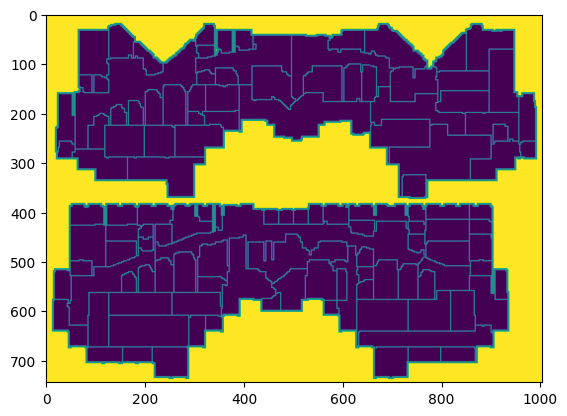

In [66]:
plt.imshow(eval_env.building._simulator._building._floor_plan)

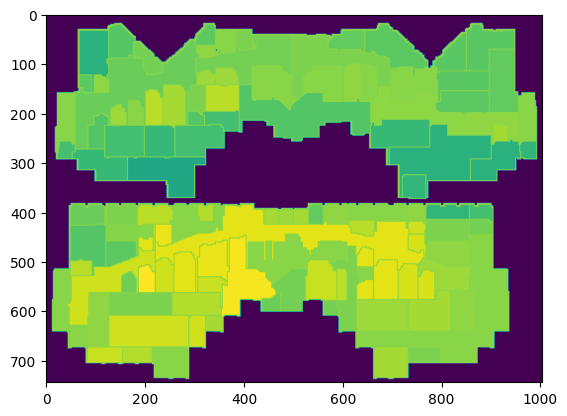

In [67]:
plt.imshow(eval_env.building._simulator._building.temp)

Environment 2023-07-06 07:00:00+00:00

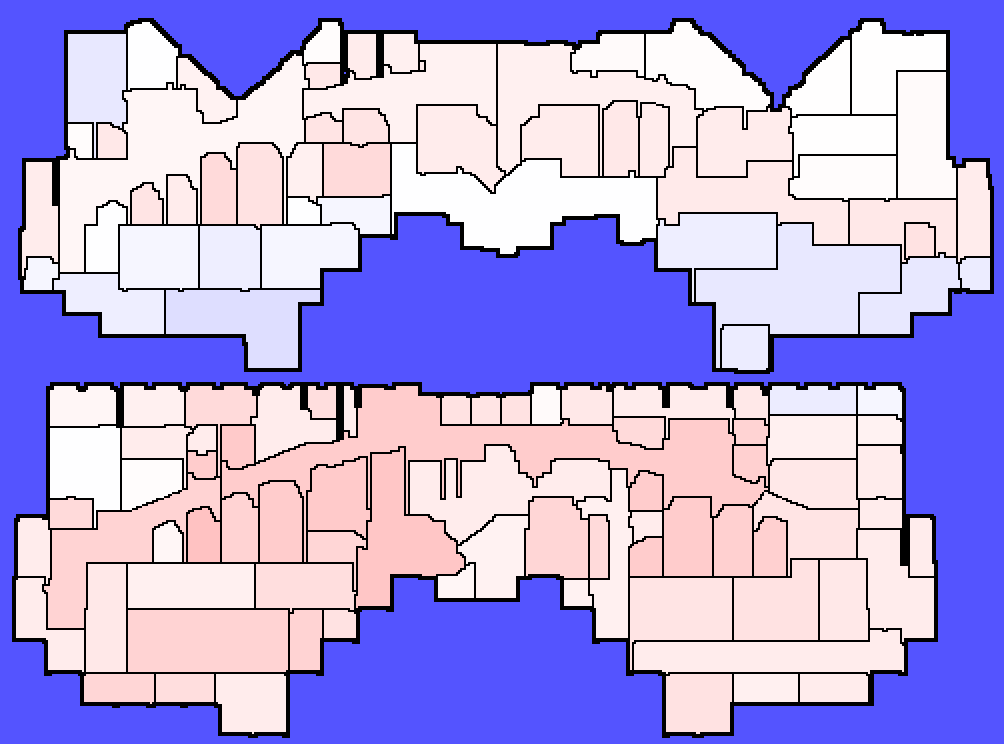

In [68]:
render_env(eval_env)

In [69]:
timestep = eval_env.reset()

In [70]:
type(timestep)

tf_agents.trajectories.time_step.TimeStep

At each time index, the environment returns 
- the discounting rate $\gamma$
- Observation state vector $\in \mathbb{R}^{53}$
- Reward
- Step Type ? 

In [71]:
import gym

In [72]:
isinstance(eval_env, gym.Env)

False

In [73]:
timestep

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-20.        , -19.128613  ,   0.        ,  -0.82162595,
        -0.5831852 ,   4.8570604 ,   0.        ,  -2.425231  ,
        -1.1068594 ,   0.        ,   2.564033  ,   1.4996233 ,
         1.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   1.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   1.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  -0.25881904,   0.9659258 ,
        -0.90096885,   0.43388373,   0.        ,   0.        ,
        -0.99206346], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

### Understanding State Space

In [99]:
field_states = eval_env._field_names # what each state dimension represents

In [100]:
field_states

['air_handler_id_44e511f8-3f4c-4dee-b9b8-345c0d8988ac_cooling_request_count',
 'air_handler_id_44e511f8-3f4c-4dee-b9b8-345c0d8988ac_differential_pressure_setpoint',
 'air_handler_id_44e511f8-3f4c-4dee-b9b8-345c0d8988ac_discharge_fan_speed_percentage_command',
 'air_handler_id_44e511f8-3f4c-4dee-b9b8-345c0d8988ac_outside_air_flowrate_sensor',
 'air_handler_id_44e511f8-3f4c-4dee-b9b8-345c0d8988ac_outside_air_temperature_sensor',
 'air_handler_id_44e511f8-3f4c-4dee-b9b8-345c0d8988ac_supply_air_cooling_temperature_setpoint',
 'air_handler_id_44e511f8-3f4c-4dee-b9b8-345c0d8988ac_supply_air_flowrate_sensor',
 'air_handler_id_44e511f8-3f4c-4dee-b9b8-345c0d8988ac_supply_air_heating_temperature_setpoint',
 'air_handler_id_44e511f8-3f4c-4dee-b9b8-345c0d8988ac_supply_fan_speed_percentage_command',
 'boiler_id_331bd1b6-eb3f-4910-b095-8c977bd75546_heating_request_count',
 'boiler_id_331bd1b6-eb3f-4910-b095-8c977bd75546_supply_water_setpoint',
 'boiler_id_331bd1b6-eb3f-4910-b095-8c977bd75546_supply_

In [98]:
def label_obs_vector(obs):
    return(pd.Series(data=observation, index=field_states))

# Action Space

In [35]:
import tensorflow as tf
from tf_agents.agents.sac import sac_agent, tanh_normal_projection_network
from tf_agents.drivers import py_driver
from tf_agents.keras_layers import inner_reshape
from tf_agents.metrics import py_metrics
from tf_agents.networks import nest_map, sequential
from tf_agents.policies import greedy_policy, py_tf_eager_policy, random_py_policy, tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer, reverb_utils
from tf_agents.specs import tensor_spec
from tf_agents.train import actor, learner, triggers
from tf_agents.train.utils import spec_utils, train_utils
from tf_agents.trajectories import policy_step
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory as trajectory_lib
from tf_agents.typing import types

In [101]:
def get_trajectory(time_step, current_action: policy_step.PolicyStep):
    """Get the trajectory for the current action and time step."""
    observation = time_step.observation
    action = current_action.action
    policy_info = ()
    reward = time_step.reward
    discount = time_step.discount

    if time_step.is_first():
        return(trajectory.first(observation, action, policy_info, reward, discount))
    elif time_step.is_last():
        return(trajectory.last(observation, action, policy_info, reward, discount))
    else:
        return(trajectory.mid(observation, action, policy_info, reward, discount))



In [39]:
def compute_avg_return(environment, policy, num_episodes=1, time_zone: str = "US/Pacific", 
                       render_interval_steps: int = 24,trajectory_observers=None,):
    """Computes the average return of the policy on the environment.
    Args:
    environment: environment.Environment
    policy: policy.Policy
    num_episodes: total number of eposides to run.
    time_zone: time zone of the environment
    render_interval_steps: Number of steps to take between rendering.
    trajectory_observers: list of trajectory observers for use in rendering.
    """
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        t0 = time.time()
        epoch = t0
        step_id = 0
        execution_times = []
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)

            if trajectory_observers is not None:
                traj = get_trajectory(time_step, action_step)
                for observer in trajectory_observers:
                    observer(traj)

            episode_return += time_step.reward
            t1 = time.time()
            dt = t1 - t0
            episode_seconds = t1 - epoch
            execution_times.append(dt)
            sim_time = environment.current_simulation_timestamp.tz_convert(time_zone)

            print("Step %5d Sim Time: %s, Reward: %8.2f, Return: %8.2f, Mean Step Time:"
                  " %8.2f s, Episode Time: %8.2f s" % (step_id, sim_time.strftime("%Y-%m-%d %H:%M"),
                                                       time_step.reward, episode_return, 
                                                       np.mean(execution_times), episode_seconds,)
                 )
            if (step_id > 0) and (step_id % render_interval_steps == 0):
                if environment._metrics_path:
                    clear_output(wait=True)
                    reader = get_latest_episode_reader(environment._metrics_path)
                    plot_timeseries_charts(reader, time_zone)
                render_env(environment)

            t0 = t1
            step_id += 1
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return